In [1]:
import numpy as np
import pandas as pd
# from tqdm import tqdm_notebook
import tqdm
from sklearn.model_selection import train_test_split

import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from matplotlib import pyplot as plt
import librosa
import librosa.display

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
col_names = ['time', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'pot_1', 'pot_2', 'pot_3']
data = pd.read_csv('/content/drive/MyDrive/Экзоскелет/G_free_random.csv', sep=';', header=None, names=col_names)

In [4]:
data

,time,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,pot_1,pot_2,pot_3
0,0.002,38.690767,1444.4553,1444.4553,1444.4553,1444.455300,412.701514,232,222,136
1,0.004,1650.806058,1444.4553,1444.4553,1444.4553,1444.455300,412.701514,232,222,136
2,0.006,1650.806058,1444.4553,1444.4553,1444.4553,1444.455300,412.701514,232,222,137
3,0.008,1650.806058,1444.4553,1444.4553,1444.4553,1444.455300,412.701514,232,221,136
4,0.010,1650.806058,1444.4553,1444.4553,1444.4553,1444.455300,412.701514,232,221,136
...,...,...,...,...,...,...,...,...,...,...
134459,268.920,1444.455300,1444.4553,1444.4553,1444.4553,1650.806058,412.701514,218,211,154
134460,268.922,1444.455300,1444.4553,1444.4553,1444.4553,1444.455300,412.701514,218,211,155
134461,268.924,1444.455300,1444.4553,1444.4553,1444.4553,1444.455300,412.701514,219,211,155
134462,268.926,1444.455300,1444.4553,1444.4553,1444.4553,1444.455300,412.701514,219,211,155


In [5]:
data[['pot_1', 'pot_2', 'pot_3']] = data[['pot_1', 'pot_2', 'pot_3']].astype(float)

In [6]:
data.dtypes

time     float64
emg_1    float64
emg_2    float64
emg_3    float64
emg_4    float64
emg_5    float64
emg_6    float64
pot_1    float64
pot_2    float64
pot_3    float64
dtype: object

In [7]:
data = data[['emg_1', 'emg_2', 'emg_3', 'emg_4', 'pot_1', 'pot_2', 'pot_3']]
data

,emg_1,emg_2,emg_3,emg_4,pot_1,pot_2,pot_3
0,38.690767,1444.4553,1444.4553,1444.4553,232.0,222.0,136.0
1,1650.806058,1444.4553,1444.4553,1444.4553,232.0,222.0,136.0
2,1650.806058,1444.4553,1444.4553,1444.4553,232.0,222.0,137.0
3,1650.806058,1444.4553,1444.4553,1444.4553,232.0,221.0,136.0
4,1650.806058,1444.4553,1444.4553,1444.4553,232.0,221.0,136.0
...,...,...,...,...,...,...,...
134459,1444.455300,1444.4553,1444.4553,1444.4553,218.0,211.0,154.0
134460,1444.455300,1444.4553,1444.4553,1444.4553,218.0,211.0,155.0
134461,1444.455300,1444.4553,1444.4553,1444.4553,219.0,211.0,155.0
134462,1444.455300,1444.4553,1444.4553,1444.4553,219.0,211.0,155.0


In [8]:
mean = data.mean()
std = data.std()
data = (data - mean) / std

In [9]:
mean

emg_1    1547.425328
emg_2    1531.923873
emg_3    1554.510368
emg_4    1534.383864
pot_1     190.219152
pot_2     197.889286
pot_3     157.878384
dtype: float64

In [10]:
data

,emg_1,emg_2,emg_3,emg_4,pot_1,pot_2,pot_3
0,-3.569975,-0.507034,-0.201626,-0.211303,1.078148,0.954066,-1.675091
1,0.244620,-0.507034,-0.201626,-0.211303,1.078148,0.954066,-1.675091
2,0.244620,-0.507034,-0.201626,-0.211303,1.078148,0.954066,-1.598527
3,0.244620,-0.507034,-0.201626,-0.211303,1.078148,0.914496,-1.675091
4,0.244620,-0.507034,-0.201626,-0.211303,1.078148,0.914496,-1.675091
...,...,...,...,...,...,...,...
134459,-0.243648,-0.507034,-0.201626,-0.211303,0.716880,0.518794,-0.296944
134460,-0.243648,-0.507034,-0.201626,-0.211303,0.716880,0.518794,-0.220380
134461,-0.243648,-0.507034,-0.201626,-0.211303,0.742685,0.518794,-0.220380
134462,-0.243648,-0.507034,-0.201626,-0.211303,0.742685,0.518794,-0.220380


In [ ]:
# # No spectrogram
# x_size = 25
# y_size = 5
# Batch_size = 50

# def create_sequences(values, x_size, y_size):
#     print(len(values))
#     X_output = []
#     Y_output = []
#     for i in range(0, len(values)-y_size - x_size, x_size): # + y_size
#         X_output.append(values[i : (i + x_size)])
#         Y_output.append(values[(i + x_size) : (i + x_size + y_size)])
#     # print(i)
#     return torch.FloatTensor(X_output).permute(0, 2, 1), torch.FloatTensor(Y_output).permute(0, 2, 1)
# #     return torch.from_numpy(np.array(X_output)).to(torch.float32).permute(0, 2, 1), torch.from_numpy(np.array(Y_output)).to(torch.float32).permute(0, 2, 1)


# X, Y = create_sequences(data.values, x_size, y_size)
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, shuffle=False)
# print("Training x input shape: ", x_train.shape)
# print("Training y input shape: ", y_train.shape)
# train_dataset = TensorDataset(x_train, y_train)
# val_dataset = TensorDataset(x_val, y_val)
# train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=True)

In [36]:
x_size = 25
y_size = 25
Batch_size = 50

def create_sequences(values, x_size, y_size):
    # print(len(values))
    X_output = []
    Y_output = []
    for i in range(0, len(values)-y_size - x_size, x_size): # + y_size
        X_output.append(values[i : (i + x_size)])
        Y_output.append(values[(i + x_size) : (i + x_size + y_size)])
    X_output = torch.FloatTensor(X_output).permute(0, 2, 1)
    Y_output = torch.FloatTensor(Y_output).permute(0, 2, 1)
    print(X_output.size())
    # print(X_output.size(), Y_output.size())
    S_x = torch.zeros(X_output.size(0), X_output.size(1)-3, 33, 13)
    print(S_x.size())
    S_y = torch.zeros(Y_output.size(0), Y_output.size(1)-3, 33, 13)
    for i in range(X_output.size(0)):
      for j in range(X_output.size(1)-3):
        S_x[i, j] = torch.FloatTensor((np.abs(librosa.stft(X_output[i, j].numpy(), n_fft=64, hop_length=2))))
    for i in range(Y_output.size(0)):
      for j in range(Y_output.size(1)-3):
        S_y[i, j] = torch.FloatTensor((np.abs(librosa.stft(Y_output[i, j].numpy(), n_fft=64, hop_length=2))))
    # print(S_x.size())
    return S_x, S_y, X_output[:,4,:], Y_output[:,4,:]

# print(np.abs(librosa.stft(X_output, n_fft=, hop_length=64)))
X_sp, Y_sp, X_coord, Y_coord = create_sequences(data.values, x_size, y_size)
X_sp_train, X_sp_val, Y_sp_train, Y_sp_val = train_test_split(X_sp, Y_sp, test_size=0.1, shuffle=False)
X_coord_train, X_coord_val, Y_coord_train, Y_coord_val = train_test_split(X_coord, Y_coord, test_size=0.1, shuffle=False)

print("Training x (spectr) input shape: ", X_sp_train.shape)
print("Training y (spectr) input shape: ", Y_sp_train.shape)
print("Training x (coord) input shape: ", X_coord_train.shape)
print("Training y (coord) input shape: ", Y_coord_train.shape)

train_dataset = TensorDataset(X_sp_train, X_coord_train, Y_coord_train)
val_dataset = TensorDataset(X_sp_val, X_coord_val, Y_coord_val)
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=False)

torch.Size([5377, 7, 25])
torch.Size([5377, 4, 33, 13])


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=64 is too small for input signal of length=25
  n_fft, y.shape[-1]


Training x (spectr) input shape:  torch.Size([4839, 4, 33, 13])
Training y (spectr) input shape:  torch.Size([4839, 4, 33, 13])
Training x (coord) input shape:  torch.Size([4839, 25])
Training y (coord) input shape:  torch.Size([4839, 25])


Применение спектрограмм

In [ ]:
# # with spectrogram
# class RNN(nn.Module):
#     def __init__(self):
#         super(RNN, self).__init__()
#         self.encoder1 = nn.Sequential(
#             nn.Conv2d(4,32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )
#         self.encoder2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
#         self.lstm1 = nn.LSTM(input_size=27481, hidden_size=256,num_layers=2, batch_first=True)

#         self.FCN = nn.Sequential(
#             nn.Linear(in_features=256, out_features=128),
#             nn.ReLU(),
#             nn.Linear(in_features=128, out_features=64),
#             nn.ReLU(),
#             nn.Linear(in_features=64, out_features=y_size)
#         )
# #             nn.ReLU(),
# #             nn.Linear(in_features=256, out_features=128),
# #             nn.ReLU(),
# #             nn.Linear(in_features=128, out_features=50),
#     def forward(self, sample_sp, sample_coord):
#         conv = self.encoder1(sample_sp)
#         latent = self.encoder2(conv)
#         x = self.decoder(latent)
#         x = x.view(x.shape[0],-1)
#         # print(x.shape)
#         # print(sample_coord.view(sample_coord.shape[0],-1).shape)
#         x = torch.cat((x, sample_coord), dim=1)
#         # print(x.shape)
#         x = self.lstm1(x)[0]
#         # print(x.shape)
#         res = self.FCN(x)
#         return res, conv

In [37]:
# with spectrogram
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.lstm1 = nn.LSTM(input_size=27481, hidden_size=256,num_layers=2, batch_first=True)

        self.FCN = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=y_size)
        )
#             nn.ReLU(),
#             nn.Linear(in_features=256, out_features=128),
#             nn.ReLU(),
#             nn.Linear(in_features=128, out_features=50),
    def forward(self, sample_sp, sample_coord):
        latent = self.encoder(sample_sp)
        x = self.decoder(latent)
        x = x.view(x.shape[0],-1)
        # print(x.shape)
        # print(sample_coord.shape)
        # print(sample_coord.view(sample_coord.shape[0],-1).shape)
        x = torch.cat((x, sample_coord), dim=1)
        # print(x.shape)
        x = self.lstm1(x)[0]
        # print(x.shape)
        res = self.FCN(x)
        return res

In [ ]:
n_epochs = 100
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'           

model = RNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm.notebook.tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for X_batch_sp, X_batch_coord, Y_batch_coord in train_loader:
        optimizer.zero_grad()
        reconstructed = model(X_batch_sp.to(device), X_batch_coord.to(device))
        loss = loss_fn(reconstructed, Y_batch_coord.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch_sp, X_batch_coord, Y_batch_coord in val_loader:
            reconstructed = model(X_batch_sp.to(device), X_batch_coord.to(device))
            loss = loss_fn(reconstructed, Y_batch_coord.to(device))
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# from sys import path
# torch.save(model.state_dict(), '/content/drive/MyDrive/Экзоскелет/RNN')

In [40]:
val_losses

[0.5088671527125619,
 0.5130164108493112,
 0.5051216564395211,
 0.5130767375230789,
 0.5186031718145717,
 0.5180467028509487,
 0.5165385549718683,
 0.4839337156577544,
 0.512169676748189,
 0.43363131108609115,
 0.46510256149552087,
 0.37181801010261883,
 0.12154437483034351,
 0.06431208313866095,
 0.04669886793602596,
 0.04227571049705148,
 0.031601752239194786,
 0.04179076130755923,
 0.03048051665113731,
 0.07179163904352621,
 0.021513255016708917,
 0.023956111462956124,
 0.023030528460036625,
 0.023151199248704044,
 0.022424264218319546,
 0.0217361565340649,
 0.014796104409139265,
 0.01804762240499258,
 0.01559584079818292,
 0.01896725222468376,
 0.01188178106465123,
 0.011754277733747254,
 0.011859831103885716,
 0.012351539790291678,
 0.012777396901087328,
 0.012683535121719946,
 0.011611659079790115,
 0.009022008183158257,
 0.0075054496251554656,
 0.006492246471514756,
 0.007987780517644504,
 0.006267639321529053,
 0.008935584845444695,
 0.007958752960389988,
 0.007682470774108713,

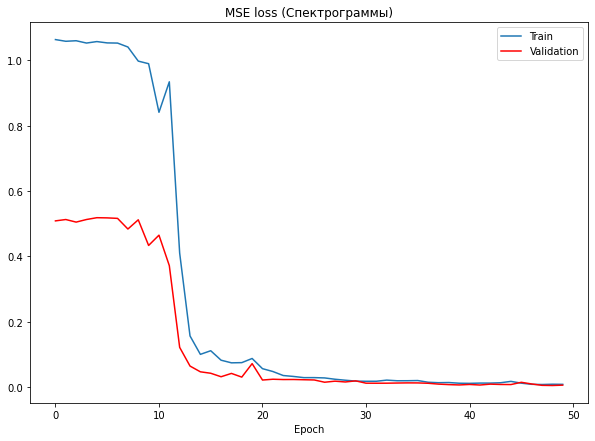

In [41]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation', color='red')

plt.xlabel('Epoch')
# plt.ylim(0, 0.5)
plt.title('MSE loss (Спектрограммы)')
plt.legend()
plt.show()

In [42]:
np.mean(val_losses)

0.13400759531904688

In [ ]:
# plt.figure(figsize=(10, 7))
# plt.plot(np.arange(len(train_losses)), np.array(train_losses)*std[4]+mean[4], label='Train')
# plt.plot(np.arange(len(val_losses)), np.array(val_losses)*std[4]+mean[4], label='Validation')

# plt.xlabel('Epoch')
# plt.ylim(0, 2000)
# plt.title('MSE loss')
# plt.legend()
# plt.show()

In [43]:
test_loader = DataLoader(train_dataset, batch_size=500, shuffle=False)

model.eval()
x_pred = []
ground = []
losses = []
times = []
with torch.no_grad():
    
    for X_batch_sp, X_batch_coord, Y_batch_coord in test_loader:
        now = time.time()
        pred = model(X_batch_sp.to(device), X_batch_coord.to(device)).cpu().numpy()
        later = time.time()
        times.append(1000*(later - now))
        x_pred.append(pred)
        ground.append(Y_batch_coord)      
        losses.append(np.mean(np.abs(pred - Y_batch_coord.numpy())))
print(sum(times)/len(times))

37.935543060302734


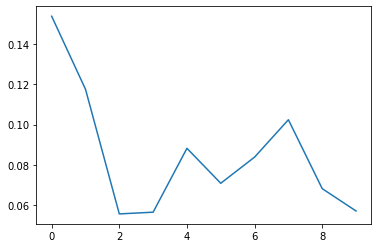

In [44]:
plt.plot(losses)

In [45]:
len(ground)

10

In [46]:
gr = []
predict = []
for i in range(len(ground[0])):
    a = ground[1][i]
    b = x_pred[1][i]
    gr.append(a)
    predict.append(b)
    

gr = torch.ravel(torch.stack(gr))
pred = np.ravel(np.stack(predict))

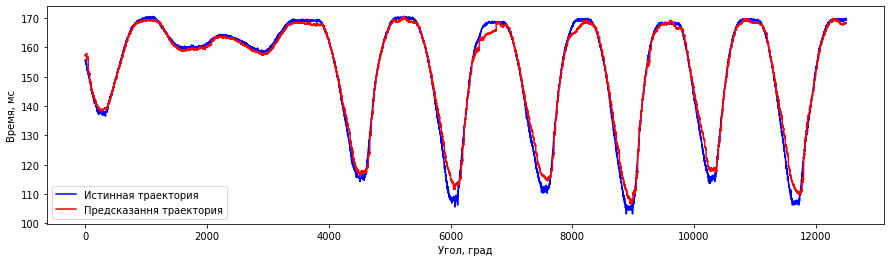

In [47]:
# shuffled
plt.figure(figsize=(15, 4))
plt.plot(gr*std[6]+mean[6], label='Истинная траектория', color='blue')
plt.plot(pred*std[6]+mean[6], label='Предсказання траектория', color='red')
# plt.plot(gr, label='Ground truth', color='blue')
# plt.plot(pred, label='Predicted', color='red')
# plt.plot(pred*std[4]+mean[4], color='red')
plt.xlabel('Угол, град')
plt.ylabel('Время, мс')
plt.legend()
# plt.savefig('/content/drive/MyDrive/Экзоскелет/saved_figure.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# # shuffled
# plt.figure(figsize=(15, 4))
# plt.plot(gr, label='Ground truth', color='blue')
# plt.plot(pred, label='Predicted', color='red')

# plt.legend()
# # plt.savefig('/content/drive/MyDrive/Экзоскелет/saved_figure.png', transparent=True, bbox_inches='tight')
# plt.show()

Text(0, 0.5, 'Время, мс')

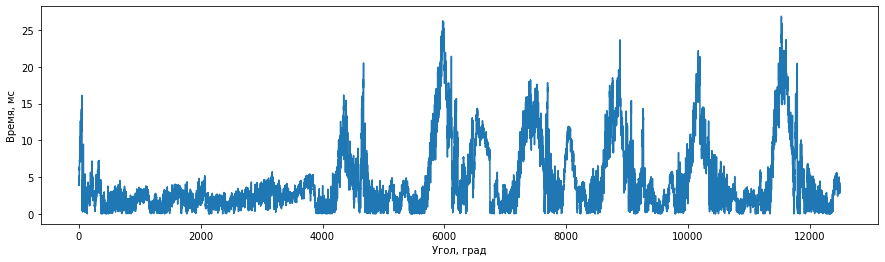

In [48]:
plt.figure(figsize=(15, 4))
gr_er = gr*std[4]+mean[4]
pred_er = pred*std[4]+mean[4]
losses = np.abs(gr_er - pred_er)
plt.plot(losses)
plt.xlabel('Угол, град')
plt.ylabel('Время, мс')

In [49]:
losses

tensor([5.1147, 3.8810, 5.2475,  ..., 2.8217, 3.8216, 3.6948])

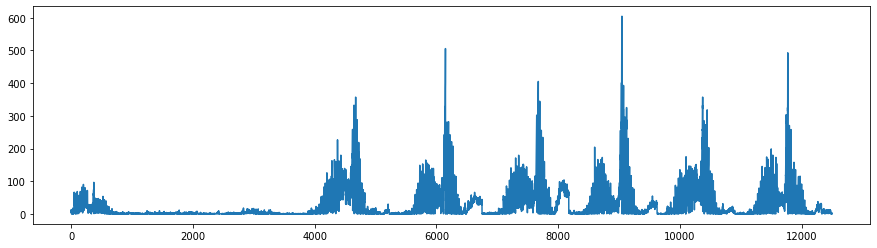

In [ ]:
# plt.figure(figsize=(15, 4))
# gr_er = gr*std[4]+mean[4]
# pred_er = pred*std[4]+mean[4]
# losses = (gr_er - pred_er)**2
# plt.plot(losses)

In [54]:
# print(np.mean(losses))
# print(len(losses))
# print(losses)

error = 10
count = 0
for el in losses:
  if el < error:
    count += 1
print(count)
print('Accuracy:', count/len(losses))

10700
Accuracy: 0.856


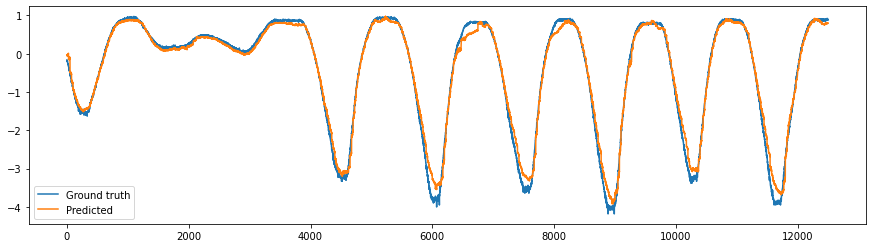

In [55]:
# no shuffled
plt.figure(figsize=(15, 4))
plt.plot(gr, label='Ground truth')
plt.plot(pred, label='Predicted')

plt.legend()
plt.show()

In [ ]:
sum(val_losses) / len(val_losses)

0.09092113632650581